In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from feature_engine.imputation import CategoricalImputer, MeanMedianImputer
from feature_engine.encoding import OrdinalEncoder, OneHotEncoder
from feature_engine.wrappers import SklearnTransformerWrapper
from sklearn.preprocessing import StandardScaler, LabelBinarizer

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.preprocessing import FunctionTransformer

from sklearn import set_config
set_config(display='diagram')
# ------------------------------------------
import nltk
import sys
import random

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer

sys.path.append('..')
import utils
from sklearn.preprocessing import FunctionTransformer

## PROPIAS
from utils import RemoveStopWords
from utils import FeatureExtractionTwitts
from utils import LemmantizerTransformer
from utils import Vectorizer
from utils import ColumnSelectedTransformer

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html

In [10]:
df = pd.read_csv('training_tweets.csv', index_col = 0)
df;

In [11]:
df.content.to_csv('raw_tweets.csv')

In [12]:
groups_classes = {
                    'happiness' : 'positiva',
                    'surprise'  : 'positiva',
                    'love'      : 'positiva',
                    'fun'       : 'positiva',
                    'relief'    : 'positiva',
                    'enthusiasm': 'positiva',
                    'worry'     : 'negativa',
                    'hate'      : 'negativa',
                    'sadness'   : 'negativa',
                    'empty'     : 'negativa',
                    'boredom'   : 'negativa',
                    'anger'     : 'negativa',
                    'neutral'   : 'neutral'
                }
neutral_class_name = 'neutral'
target_var_name = 'sentiment'
target_mapping = [('positiva',1),('negativa',0)]
chars_to_replace = [
                        ('ï¿½',''),
                        ('&quot;',''),
                        ('&lt;3','<3'), 
                        ('&lt;/3','</3'), 
                        ('&amp;','&'),
                        ('&gt;','>'),
                        ('&lt;','<')
                    ]


In [13]:
from sklearn.compose import TransformedTargetRegressor
df_preprocess = Pipeline(steps=[
                ('regroup_classes', 
                    FunctionTransformer(
                        utils.multi_class_remapping, 
                        kw_args={
                            'group_classes': groups_classes,
                            'var_name': target_var_name,
                            'neutral_class': neutral_class_name,
                            'random_state': 42
                            })),
                ('encoding', FunctionTransformer(
                        utils.target_encoding,
                        kw_args={
                            'column_to_encode': 'sentiment_remapped', 'mapping':target_mapping})),
])

df = df_preprocess.fit_transform(df) #
df
# Este debiese ser la primera transformación, no se si serializar esto o no pero habría que indicar que es necesario aplicarlo a df para poder continuar.

,content,sentiment,sentiment_remapped
34723,Happy Mama's day to all mothers,love,1
17493,@LysdelTellez I am lost. Please help me find a...,worry,0
20198,"@BoomKatt yes yes I AM, networking whore to th...",happiness,1
6855,you@snapplynn Wish that would have been your t...,neutral,0
5924,now i am doing the MicroEconomics project iha...,worry,0
...,...,...,...
16469,I do not want to work tomorrow!,sadness,0
36006,@KandyBee we shuld do a dance like that its s...,fun,1
22647,"Photo: Got my prints a few days ago, ready for...",happiness,1
21478,@tove_liden Thanks for the follow Tove!,fun,1


In [14]:
# Todos los pipelines siguientes deberían vivir en un solo pipeline y al final aplicar fit_transform. Se debe serializar ese ultimo pipeline

# hiperparametros posibles:
# usar o no STOPWORDS
# stemmers = 'ps' | 'wnl' | 'sno'

preprocessing = Pipeline(steps=[
                ('rc', FunctionTransformer(utils.remove_chars, kw_args={'var_name': 'content', 'char_list': chars_to_replace})),
                ('ra', FunctionTransformer(utils.remove_arrobas, kw_args= {'var_name':'content_remchars'})),
                ('rl', FunctionTransformer(utils.remove_links, kw_args={'var_name': 'content_remchars_remarroba'})),
                ('rsw', RemoveStopWords(text_columns = ['content_remchars_remarroba_remlinks'])),
                ('lt', LemmantizerTransformer(text_columns = ['content_remchars_remarroba_remlinks_sw'], stemmers=['ps'])),
                
])

# hiperparametros posibles:
# usar o no STOPWORDS
# min_df = 1,2,3...
# vect_type = 'count' | 'tfid'

# Si se quiere ver los resultados de las limpiezas de los textos, comentar la linea de ColumnSelectedTransformer y luego ver el dataframe. También se pueden ver los reportes generados en csv y txt en la carpeta raíz.

feature_extraction = Pipeline(steps=[
                ('fet_1', FeatureExtractionTwitts(
                    text_column="content",
                    features_to_extract=[
                        "arrobas_count", "hashtag_count", "is_reply", "is_rt", "twitt_length"]
                    )),
                ('fet_2', FeatureExtractionTwitts(
                    text_column="content_remchars_remarroba_remlinks_sw_ps",
                    features_to_extract = ["subjectivity", "polarity"]
                    )),
                ('ctr', Vectorizer(vect_type='count', text_column='content_remchars_remarroba_remlinks_sw_ps', min_df = 10)),
                ('ds', ColumnSelectedTransformer(vars_prefix='var_'))
                
])

# joblib.load


In [15]:
from sklearn.ensemble import StackingClassifier



clf1 = GaussianNB()
clf2 = KNeighborsClassifier()
clf3 = SVC(random_state=42, probability=True)
clf4 = GradientBoostingClassifier(random_state=42)

meta0 = LogisticRegression(random_state=42)
meta1 = RandomForestClassifier(random_state=42)
meta2 = GradientBoostingClassifier(random_state=42)

estimators = [('gnb', clf1), ('gbc', clf4)]


# final estimator: metaestimator
st_1 = StackingClassifier(estimators=estimators,
                        final_estimator=meta2,
                        cv=5)

model_and_scale = Pipeline(steps=[
    ('sc', StandardScaler()),
    ('model', st_1)
])


In [16]:
pipe = Pipeline(steps=[
    ('preprocessing', preprocessing),
    ('feature_extraction', feature_extraction),
    # ('model', model_and_scale)
])

X = df[['content']]
y = df.sentiment_remapped

X_tr = pipe.fit_transform(X,y)



def train_function(pipe, X_train, X_test, y_train, y_test):
    pipe.fit(X_train, y_train)
    y_pred_train = pipe.predict(X_train)
    y_pred = pipe.predict(X_test)
    print('train')
    print(classification_report(y_train, y_pred_train, digits=4))
    print('test')
    print(classification_report(y_test, y_pred, digits=4))
    return pipe
    
X_train, X_test, y_train, y_test = train_test_split(X_tr, y, test_size=.2, random_state=42)
train_function(model_and_scale, X_train, X_test, y_train, y_test)


train
              precision    recall  f1-score   support

           0     0.7354    0.6335    0.6806     12168
           1     0.6701    0.7656    0.7147     11832

    accuracy                         0.6986     24000
   macro avg     0.7028    0.6996    0.6977     24000
weighted avg     0.7032    0.6986    0.6974     24000

test
              precision    recall  f1-score   support

           0     0.6944    0.6080    0.6483      3038
           1     0.6434    0.7255    0.6820      2962

    accuracy                         0.6660      6000
   macro avg     0.6689    0.6667    0.6652      6000
weighted avg     0.6692    0.6660    0.6649      6000



Pipeline(steps=[('sc', StandardScaler()),
                ('model',
                 StackingClassifier(cv=5,
                                    estimators=[('gnb', GaussianNB()),
                                                ('gbc',
                                                 GradientBoostingClassifier(random_state=42))],
                                    final_estimator=GradientBoostingClassifier(random_state=42)))])

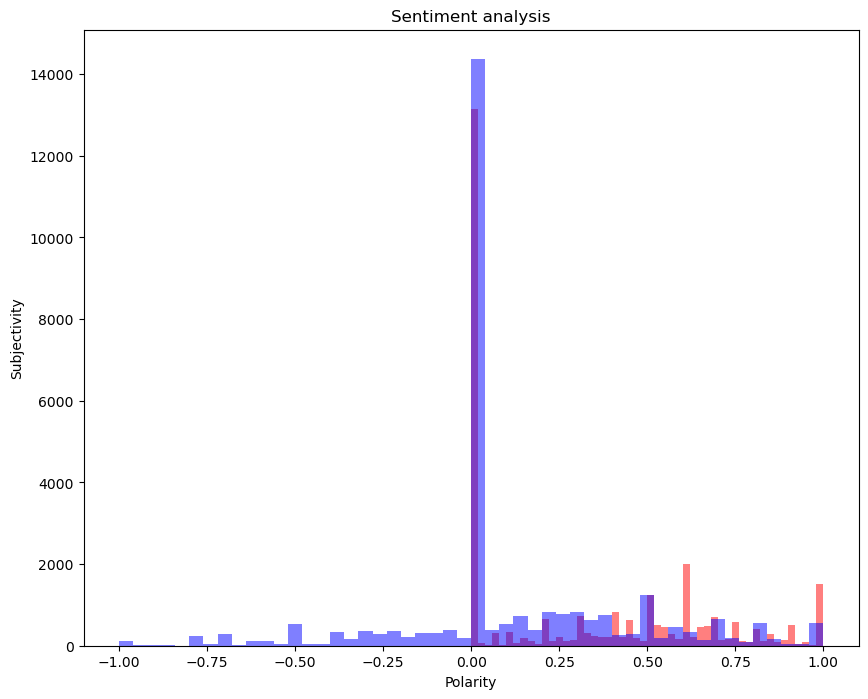

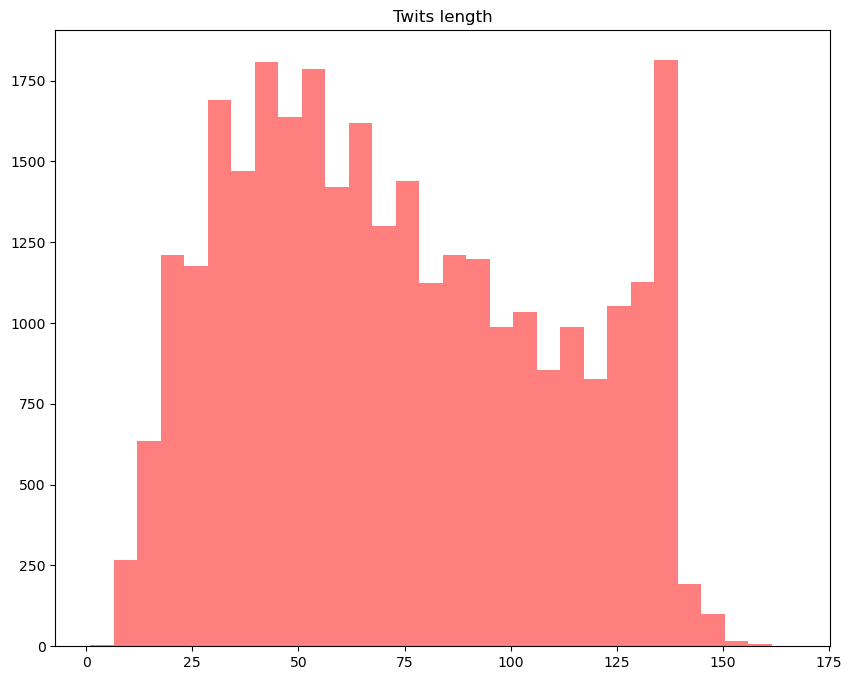

In [17]:
plt.figure(figsize=(10, 8))
plt.hist(X_tr['var_subjectivity'], bins=50, fc=(1, 0, 0, 0.5))
plt.hist(X_tr['var_polarity'], bins=50, fc=(0, 0, 1, 0.5))
plt.title('Sentiment analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')
plt.show()

plt.figure(figsize=(10, 8))
plt.hist(X_tr['var_twit_length'], bins=30, fc=(1, 0, 0, 0.5))
plt.title('Twits length')
plt.show()

